In [1]:
import os
from glob import glob
import numpy as np
import h5py
import matplotlib.pyplot as plt
plt.style.use('figure.mplstyle')

from function.data2p import get_data_bis

In [2]:
folder = r'D:\LW_Alldata\SI_Transient'
alldata = {'Enriched': glob(os.path.join(folder,'Enriched*.hdf5')),
           'Dissimilar': glob(os.path.join(folder,'Distinct*.hdf5')),
           'Similar': glob(os.path.join(folder,'Similar*.hdf5'))}
datapath = alldata['Enriched'][2]
day = 1  # Recording days, None for all days
min_rate = 1/60  # Minimum transient rate for active cells
pval_thr = 0.05  # Threshold for significant spatial information

In [3]:
## Load all cells first
data, cells, days, ctx, _ = get_data_bis(datapath, day=day, min_rate=0)

with h5py.File(datapath, 'r') as f:
    yrange = f['params/yrange'][()]  # Dataset dependent
    
print('Recording days:', days)
print('Context fam/nov:', ctx)

Recording days: [1 1 1 1]
Context fam/nov: [0 1 0 1]


In [4]:
def get_active_cells(data, cells, min_rate=1/60):
    
    active = (cells['trate'] >= min_rate).T  # (nctx, ncell) if one day
    selected = np.any(active, axis=0)
    AC = np.array([np.sum(np.all(~active, axis=0)),  # None
                   np.sum(active[0] & ~active[1]),  # Exclusively Fam
                   np.sum(np.all(active, axis=0)),  # Both
                   np.sum(active[1] & ~active[0])])  # Exclusively Nov
    
    for k in range(len(data['F'])):
        for key in ['F','Tr','Sp']:
            data[key][k] = data[key][k][selected]
    for key in cells.keys():
        cells[key] = cells[key][selected]
        
    return data, cells, selected, AC

data, cells, selected, AC = get_active_cells(data, cells, min_rate=min_rate)
print('-'*36)
print('Total cells:', len(selected))
print('Active cells:', np.sum(selected))
print('Proportion of active cells %.2f %%' % (np.sum(selected)/len(selected)*100))
print('Active in both %.2f %%' % (AC[2]/len(selected)*100))
print('Active exclusively in Fam %.2f %%' % (AC[1]/len(selected)*100))
print('Active exclusively in Nov %.2f %%' % (AC[3]/len(selected)*100))
print('-'*36)

------------------------------------
Total cells: 90
Active cells: 75
Proportion of active cells 83.33 %
Active in both 38.89 %
Active exclusively in Fam 21.11 %
Active exclusively in Nov 23.33 %
------------------------------------


In [5]:
def get_place_cells(cells, pval_thr=0.05):
    
    significant = (cells['si_pvalue'] <= pval_thr).T  # (nctx, ncell) if one day
    place_cells = np.any(significant, axis=0)
    PC = np.array([np.sum(np.all(~significant, axis=0)),  # None
                   np.sum(significant[0] & ~significant[1]),  # Exclusively Fam
                   np.sum(np.all(significant, axis=0)),  # Both
                   np.sum(significant[1] & ~significant[0])])  # Exclusively Nov
    
    return place_cells, PC

place_cells, PC = get_place_cells(cells, pval_thr=pval_thr)
ncell = data['F'][0].shape[0]
print('-'*36)
print('Active cells: ', ncell)
print('Place cells: ', np.sum(place_cells))
print('Proportion of place cells %.2f %%' % (np.sum(place_cells)/ncell*100))
print('PC in both %.2f %%' % (PC[2]/ncell*100))
print('PC exclusively in Fam %.2f %%' % (PC[1]/ncell*100))
print('PC exclusively in Nov %.2f %%' % (PC[3]/ncell*100))
print('-'*36)

------------------------------------
Active cells:  75
Place cells:  56
Proportion of place cells 74.67 %
PC in both 21.33 %
PC exclusively in Fam 24.00 %
PC exclusively in Nov 29.33 %
------------------------------------


## Run for all datasets

In [6]:
AC_list, PC_list = [], []
for p, key in enumerate(['Enriched','Dissimilar','Similar']):
    datasets = alldata[key]
    ACs, PCs = [], []
    for datapath in datasets:
        data, cells, days, ctx, _ = get_data_bis(datapath, day=1, min_rate=0)
        data, cells, selected, AC = get_active_cells(data, cells, min_rate=min_rate)
        place_cells, PC = get_place_cells(cells, pval_thr=pval_thr)
        ACs.append(AC)
        PCs.append(PC)
    AC_list.append(np.vstack(ACs).sum(axis=0))
    PC_list.append(np.vstack(PCs).sum(axis=0))

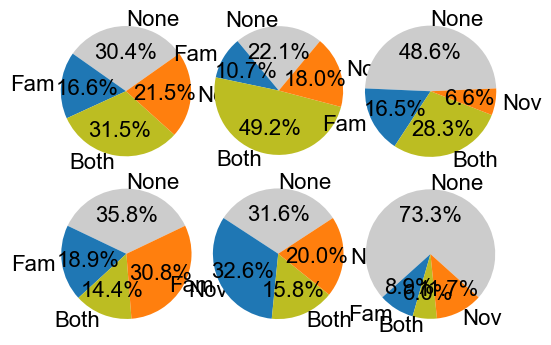

In [9]:
def pie_chart(sizes, labels, ax):

    angle = sizes[0]/sum(sizes)*360  # Angle of the 1st part
    ax.pie(sizes, labels=labels, colors=[(0.8,)*3,'C0','tab:olive','C1'],
           startangle=90-angle/2, autopct='%1.1f%%')  # wedgeprops=dict(width=1, edgecolor='k')
    ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle

fig, axs = plt.subplots(2,3,figsize=(5.8,4.2))
labels = ['None','Fam','Both','Nov']
for p in range(3):
    pie_chart(AC_list[p], labels, axs[0,p])
    pie_chart(PC_list[p], labels, axs[1,p])
fig.subplots_adjust(wspace=0.05, hspace=0.01)
fig.savefig('Cells proportion.svg')